# Experiment 2: Bias Detection and Fairness Analysis

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# Load data
df = pd.read_csv("xgboost_data.csv")
df.head()

,Unnamed: 0,ZipCode,YEAR,RegionID,City,Metro,CountyName,HOME_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%),NUM_FIRES,TOTAL_ACRES_BURNED_IN_ZIP,AVG_FIRE_DURATION_DAYS,MAX_PCT_ZIP_BURNED,ANY_MAJOR_FIRE,FIRE_EXPOSED
0,0,90001,2012,95982,Florence-Graham,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,173120.150950,40741.986132,23.533936,NaN,NaN,NaN,NaN,NaN,0
1,1,90001,2013,95982,Florence-Graham,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,213862.137082,36859.316468,17.235083,NaN,NaN,NaN,NaN,NaN,0
2,2,90001,2014,95982,Florence-Graham,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,250721.453550,4484.383699,1.788592,NaN,NaN,NaN,NaN,NaN,0
3,3,90001,2015,95982,Florence-Graham,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,255205.837249,25174.378994,9.864343,NaN,NaN,NaN,NaN,NaN,0
4,4,90001,2016,95982,Florence-Graham,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,280380.216244,51139.857090,18.239467,NaN,NaN,NaN,NaN,NaN,0


### Build XGBoost Model

In [12]:
# Feature selection
features = ['YEAR', 'ZipCode', 'RegionID', 'FIRE_EXPOSED',
            'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 
            'AVG_FIRE_DURATION_DAYS', 'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE']

# Handle missing values
df[features] = df[features].fillna(0)

# Prepare X and y
X = df[features]
y = df['HOME_PRICE']

# Label Encoding for categorical features
for col in ['ZipCode', 'RegionID']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

C:\Users\Leo\AppData\Local\Temp\ipykernel_18600\3316463473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\Leo\AppData\Local\Temp\ipykernel_18600\3316463473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


### Income Group Assignment and Bias Metrics Calculation

In this section, we first simulate median income values for each ZipCode. 
Then, we assign each ZipCode into a high-income or low-income group based on the median of all incomes.

After building the XGBoost model, we match the predicted prices back to the original test samples along with their ZipCodes. 
We merge the income information into the prediction results and assign each prediction to an income group.

We calculate the absolute error (|PredictedPrice - TruePrice|) and the residual (PredictedPrice - TruePrice) for each sample.
Finally, we group the results by income group and compute two metrics for each group:
- Mean Absolute Error (MAE)
- Mean Residual Bias

In [13]:
# Simulate income data for ZipCodes
np.random.seed(42)
zip_income = pd.DataFrame({
    'ZipCode': df['ZipCode'].unique(),
    'MedianIncome': np.random.randint(40000, 120000, size=df['ZipCode'].nunique())
})

# Merge income into original dataframe
df = df.merge(zip_income, on='ZipCode', how='left')

# Assign income group
income_median = zip_income['MedianIncome'].median()
df['IncomeGroup'] = np.where(df['MedianIncome'] >= income_median, 'High', 'Low')

# Match test predictions back to original dataframe
X_test_reset = X_test.reset_index()
y_test_reset = y_test.reset_index()
predictions = pd.DataFrame({
    'ZipCode': df.loc[y_test_reset['index'], 'ZipCode'].values,
    'TruePrice': y_test_reset['HOME_PRICE'].values,
    'PredictedPrice': y_pred
})

# Merge income group info
predictions = predictions.merge(zip_income, on='ZipCode', how='left')
predictions['IncomeGroup'] = np.where(predictions['MedianIncome'] >= income_median, 'High', 'Low')

# Calculate Absolute Error and Residual
predictions['AbsError'] = np.abs(predictions['PredictedPrice'] - predictions['TruePrice'])
predictions['Residual'] = predictions['PredictedPrice'] - predictions['TruePrice']

# Group by IncomeGroup
group_stats = predictions.groupby('IncomeGroup').agg(
    MAE=('AbsError', 'mean'),
    ResidualBias=('Residual', 'mean')
).reset_index()

print(group_stats)

  IncomeGroup            MAE  ResidualBias
0        High  177417.140543  -2737.074595
1         Low  167643.421244   7390.416269


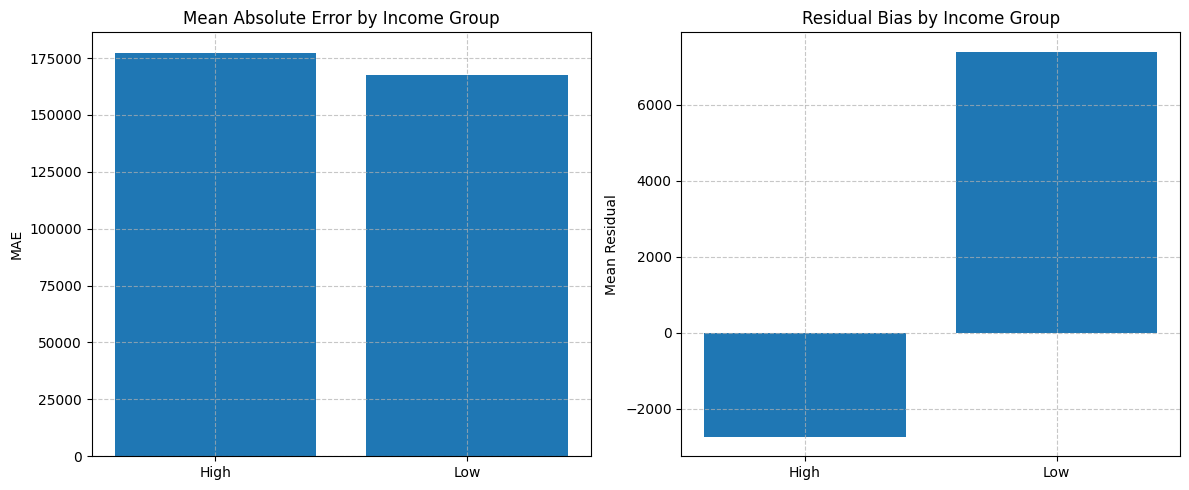

In [10]:
# Plot MAE and Residual Bias
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# MAE
axs[0].bar(group_stats['IncomeGroup'], group_stats['MAE'])
axs[0].set_title('Mean Absolute Error by Income Group')
axs[0].set_ylabel('MAE')
axs[0].grid(True, linestyle='--', alpha=0.7)

# Residual Bias
axs[1].bar(group_stats['IncomeGroup'], group_stats['ResidualBias'])
axs[1].set_title('Residual Bias by Income Group')
axs[1].set_ylabel('Mean Residual')
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Result Analysis

From the results, we observe that the Mean Absolute Error (MAE) is slightly higher for the high-income group compared to the low-income group. This suggests that the model's prediction errors are slightly larger when predicting home prices in high-income ZIP codes.

For residual bias, the high-income group shows a negative mean residual, meaning the model tends to slightly underestimate home prices for high-income areas. In contrast, the low-income group has a positive mean residual, indicating a slight overestimation.

Overall, although the differences are not very large, there is some evidence of systematic bias across income groups. This highlights the need for fairness adjustments to ensure consistent model performance across different economic segments.

In [14]:
from scipy.stats import ttest_ind

# Split into high and low income groups
high_income_errors = predictions[predictions['IncomeGroup'] == 'High']['AbsError']
low_income_errors = predictions[predictions['IncomeGroup'] == 'Low']['AbsError']

# Perform t-test on Absolute Error
t_stat_error, p_value_error = ttest_ind(high_income_errors, low_income_errors, equal_var=False)

# Perform t-test on Residuals
high_income_residual = predictions[predictions['IncomeGroup'] == 'High']['Residual']
low_income_residual = predictions[predictions['IncomeGroup'] == 'Low']['Residual']

t_stat_residual, p_value_residual = ttest_ind(high_income_residual, low_income_residual, equal_var=False)

print("T-test for Absolute Error between High and Low Income Groups:")
print(f"t-statistic = {t_stat_error:.4f}, p-value = {p_value_error:.4f}")

print("\nT-test for Residuals between High and Low Income Groups:")
print(f"t-statistic = {t_stat_residual:.4f}, p-value = {p_value_residual:.4f}")

T-test for Absolute Error between High and Low Income Groups:
t-statistic = 0.8925, p-value = 0.3722

T-test for Residuals between High and Low Income Groups:
t-statistic = -0.7574, p-value = 0.4489


In [16]:
# Divide ZipCodes into four groups based on MedianIncome quartiles
predictions['IncomeQuartile'] = pd.qcut(predictions['MedianIncome'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Group by IncomeQuartile
quartile_stats = predictions.groupby('IncomeQuartile').agg(
    MAE=('AbsError', 'mean'),
    ResidualBias=('Residual', 'mean')
).reset_index()

print(quartile_stats)

  IncomeQuartile            MAE  ResidualBias
0             Q1  173444.268217  13731.235932
1             Q2  161903.634556  -1691.523590
2             Q3  161096.901743  19141.417696
3             Q4  193438.441443 -21608.363056


C:\Users\Leo\AppData\Local\Temp\ipykernel_18600\2776840357.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = predictions.groupby('IncomeQuartile').agg(


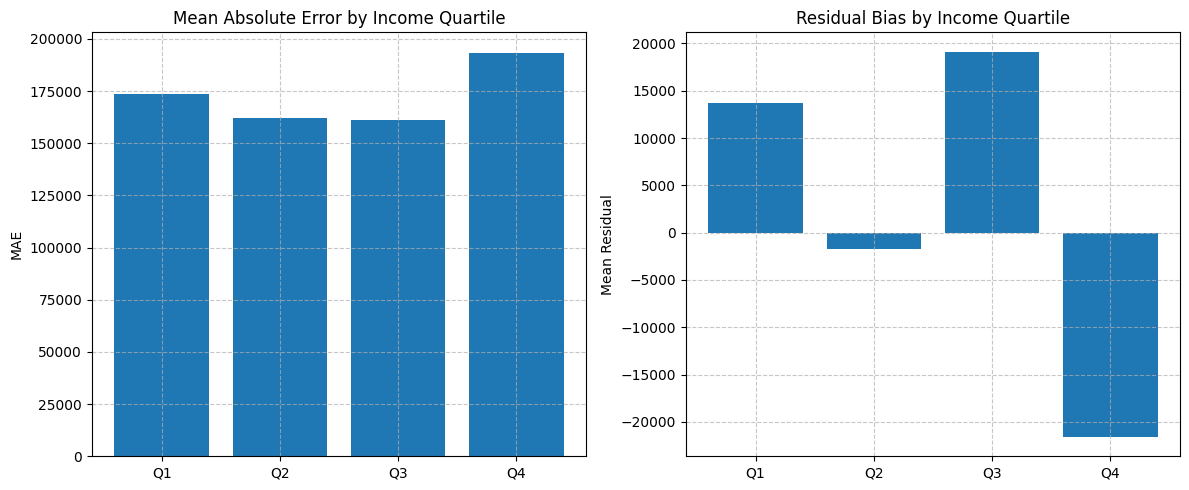

In [17]:
# Plot MAE and Residual Bias by Income Quartile
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# MAE plot
axs[0].bar(quartile_stats['IncomeQuartile'], quartile_stats['MAE'])
axs[0].set_title('Mean Absolute Error by Income Quartile')
axs[0].set_ylabel('MAE')
axs[0].grid(True, linestyle='--', alpha=0.7)

# Residual Bias plot
axs[1].bar(quartile_stats['IncomeQuartile'], quartile_stats['ResidualBias'])
axs[1].set_title('Residual Bias by Income Quartile')
axs[1].set_ylabel('Mean Residual')
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()